# Intro

A classifier was trained (and pickled) using all the vectors in *data/bccba/VECTOR/Roi_Para_Clasificar/*

Now all the image will be classified and the vector in *data/bccba/VECTOR/CLASIFICACION_PuntosControl/* will be used to asses the results.

To use that vector, we need to modify it: the classes names are strings and we need to match them with the numer


In [39]:
%matplotlib notebook
import numpy as np
import os
import pickle
import sys

from matplotlib import pyplot as plt
from osgeo import gdal, ogr
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from landsat8 import write_geotiff

from utils import (
    print_cm, test_class_name_to_train_label, extract_test_mask, add_label_from_reference_name,
    separate_files_by_date, TEST_TO_TRAIN_CLASS_NAME)

gdal.UseExceptions()

### Settings

In [40]:
# Raster location
data_date = "150321"
raster_data_path = "real_data/%s/img/L8_229_82_%s.tif" % (data_date, data_date)

# Pickled data
trained_classifier_path = "classifier_trained_%s.pickle" % data_date
predicted_classifier_path = "classifier_predicted_%s.pickle" % data_date

# Output file
output_fname = "classification_%s.tiff" % data_date

In [41]:
print("Reading the input: %s" % raster_data_path)
try:
    raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)
except RuntimeError as e:
    report_and_exit(str(e))

geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
bands_data = []
for b in range(1, raster_dataset.RasterCount + 1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape
# A sample is a vector with all the bands data. Each pixel (independent of its position) is a
# sample.
n_samples = rows * cols

Reading the input: real_data/150321/img/L8_229_82_150321.tif


# Classification

In [42]:
with open(trained_classifier_path, 'rb') as trained_classifier_file:
    training = pickle.load(trained_classifier_file)

classifier = training['classifier']
training_reference = training['reference']

In [43]:
training_reference

{'ALFA': 1,
 'MAIZ': 2,
 'MANI': 3,
 'MONTE': 4,
 'PN': 5,
 'RASTROJO': 6,
 'SOJA': 7,
 'SORGO': 8}

Predict by chunks

In [44]:
flat_pixels = bands_data.reshape((n_samples, n_bands))
result = np.array([])
chunk_size = 100  # Number of rows
chunk_nr = 0
while chunk_nr*chunk_size < rows:
    start = chunk_nr*cols*chunk_size
    end  = start + cols*chunk_size
    chunk = flat_pixels[start: end]
    predicted_chunk = classifier.predict(chunk)
    result = np.concatenate([result, predicted_chunk])
    chunk_nr += 1
# Free some space
del(flat_pixels)
del(bands_data)

In [45]:
classification = result.reshape((rows, cols))
dump_data = {
    'classification': classification,
    'reference': training_reference
}
with open(predicted_classifier_path, 'wb') as predicted_classifier_file:
    pickle.dump(dump_data, predicted_classifier_file)

<IPython.core.display.Javascript object>


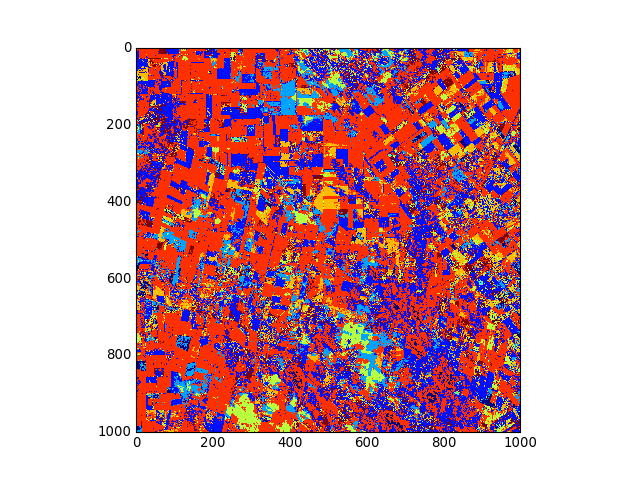

In [46]:
plt.figure()
plt.imshow(classification[5000:6000, 5000:6000], interpolation='none')

In [47]:
write_geotiff(output_fname, classification, geo_transform, proj)
print("Classification created: %s" % output_fname)

Classification created: classification_150321.tiff


# Verification/Test

In [48]:
verification_vector_data_path = "real_data/puntos_control/CLASIFICACION_Y_ROI.shp"
# Esto se hace una sola vez
add_label_from_reference_name(verification_vector_data_path)

In [49]:
test_ds = extract_test_mask(verification_vector_data_path, rows, cols, geo_transform, proj, 'reference')

In [50]:
test_band = test_ds.GetRasterBand(1)
labeled_pixels = test_band.ReadAsArray()

In [51]:
output_fname = "verification_%s.tiff" % data_date
write_geotiff(output_fname, labeled_pixels, geo_transform, proj)
print("Verification image created: %s" % output_fname)

Verification image created: verification_150321.tiff


In [52]:
for klass, label in training_reference.items():
    print("%s [%i]: %i test pixels" % (klass, label, labeled_pixels[labeled_pixels==label].shape[0]))
    print("%s [%i]: %i predicted pixels" % (klass, label, classification[classification==label].shape[0]))

MONTE [4]: 0 test pixels
MONTE [4]: 754686 predicted pixels
PN [5]: 1323 test pixels
PN [5]: 19090847 predicted pixels
SOJA [7]: 94784 test pixels
SOJA [7]: 19055455 predicted pixels
SORGO [8]: 3260 test pixels
SORGO [8]: 1418243 predicted pixels
MANI [3]: 9089 test pixels
MANI [3]: 1676117 predicted pixels
MAIZ [2]: 26811 test pixels
MAIZ [2]: 13191754 predicted pixels
RASTROJO [6]: 0 test pixels
RASTROJO [6]: 2511721 predicted pixels
ALFA [1]: 0 test pixels
ALFA [1]: 2037393 predicted pixels


In [53]:
for_verification = labeled_pixels.nonzero()
verification_labels = labeled_pixels[for_verification]
predicted_labels = classification[for_verification]

In [54]:
cm = metrics.confusion_matrix(verification_labels, predicted_labels)

In [55]:
train_classes = sorted(training_reference, key= lambda x: training_reference[x])
train_to_test = {train_name: test_name for test_name, train_name in TEST_TO_TRAIN_CLASS_NAME.items()}
classes_labels = [train_to_test.get(c, c[:3]) for c in train_classes]
print_cm(cm, classes_labels)


   	ALF	 MZ	 MN	MON	 PN	RAS	 SJ	SRG	
ALF	  0	  0	  0	  0	  0	  0	  0	  0	
 MZ	168	18475	2204	170	1667	1696	2065	366	
 MN	1011	526	6528	 22	244	240	413	105	
MON	  0	  0	  0	  0	  0	  0	  0	  0	
 PN	171	145	 75	  3	348	133	355	 93	
RAS	  0	  0	  0	  0	  0	  0	  0	  0	
 SJ	1358	6649	4450	 94	2828	5713	71339	2353	
SRG	 12	1063	 23	  3	 21	219	1383	536	


In [56]:
print("Classification accuracy: %f" %
      metrics.accuracy_score(verification_labels, predicted_labels))

Classification accuracy: 0.718771


In [57]:
print("Classification report:\n%s" %
      metrics.classification_report(verification_labels, predicted_labels,
                                    target_names=classes_labels))

Classification report:
             precision    recall  f1-score   support

        ALF       0.00      0.00      0.00         0
         MZ       0.69      0.69      0.69     26811
         MN       0.49      0.72      0.58      9089
        MON       0.00      0.00      0.00         0
         PN       0.07      0.26      0.11      1323
        RAS       0.00      0.00      0.00         0
         SJ       0.94      0.75      0.84     94784
        SRG       0.16      0.16      0.16      3260

avg / total       0.84      0.72      0.77    135267



/home/jbigatti/.virtualenvs/satimg/lib/python3.4/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
